In [15]:
import librosa as lr
import soundfile as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import torch
import torchaudio

In [13]:
import librosa

In [17]:
# convert mp3 to wav
mp3_file = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\24_preludes_for_solo_piano\jan_hanford-24_preludes_for_solo_piano-01-prelude_no__1_in_f_minor-30-59.mp3"
filename = r"C:\Users\jiyun\Desktop\Jiyu\2020-2021\ESC499 - Thesis\WaveNet\magnatagatune\data\24_preludes_for_solo_piano_wav\jan_hanford-24_preludes_for_solo_piano-01-prelude_no__1_in_f_minor-30-59.wav"
y, sr = lr.load(mp3_file)
sf.write(filename, y, sr)

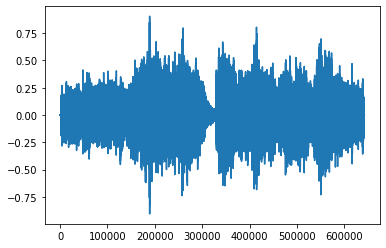

In [20]:
# raw waveform
waveform, sr = torchaudio.load(filename)
plt.figure()
plt.plot(waveform.t().numpy())
plt.show()

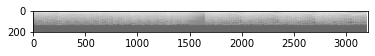

In [23]:
# spectrogram
specgram = torchaudio.transforms.Spectrogram()(waveform)
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')
plt.show()